In [1]:
# Change to a directory where you want to store the data
%cd /content/

# Download the protocol file and one training partition
!wget https://zenodo.org/record/14498691/files/ASVspoof5_protocols.tar.gz
#!wget https://zenodo.org/record/14498691/files/flac_D_aa.tar

!wget https://zenodo.org/record/14498691/files/flac_T_aa.tar
# Extract the downloaded archives
!tar -xzvf ASVspoof5_protocols.tar.gz
#!tar -xvf flac_D_aa.tar
!tar -xvf flac_T_aa.tar


Streaming output truncated to the last 5000 lines.
flac_T/T_0000031500.flac
flac_T/T_0000031501.flac
flac_T/T_0000031502.flac
flac_T/T_0000031503.flac
flac_T/T_0000031504.flac
flac_T/T_0000031505.flac
flac_T/T_0000031506.flac
flac_T/T_0000031507.flac
flac_T/T_0000031508.flac
flac_T/T_0000031509.flac
flac_T/T_0000031510.flac
flac_T/T_0000031511.flac
flac_T/T_0000031512.flac
flac_T/T_0000031513.flac
flac_T/T_0000031514.flac
flac_T/T_0000031515.flac
flac_T/T_0000031516.flac
flac_T/T_0000031517.flac
flac_T/T_0000031518.flac
flac_T/T_0000031519.flac
flac_T/T_0000031520.flac
flac_T/T_0000031521.flac
flac_T/T_0000031522.flac
flac_T/T_0000031523.flac
flac_T/T_0000031524.flac
flac_T/T_0000031525.flac
flac_T/T_0000031526.flac
flac_T/T_0000031527.flac
flac_T/T_0000031528.flac
flac_T/T_0000031529.flac
flac_T/T_0000031530.flac
flac_T/T_0000031531.flac
flac_T/T_0000031532.flac
flac_T/T_0000031533.flac
flac_T/T_0000031534.flac
flac_T/T_0000031535.flac
flac_T/T_0000031536.flac
flac_T/T_0000031537.flac

Epoch 1: 100%|██████████| 2/2 [00:30<00:00, 15.22s/it]


Epoch 1: Train Loss: 0.2074, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 2: 100%|██████████| 2/2 [00:10<00:00,  5.32s/it]


Epoch 2: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 3: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


Epoch 3: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 4: 100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


Epoch 4: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 5: 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]


Epoch 5: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 6: 100%|██████████| 2/2 [00:09<00:00,  4.83s/it]


Epoch 6: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 7: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


Epoch 7: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 8: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]


Epoch 8: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 9: 100%|██████████| 2/2 [00:08<00:00,  4.32s/it]


Epoch 9: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


Epoch 10: 100%|██████████| 2/2 [00:09<00:00,  4.93s/it]


Epoch 10: Train Loss: 0.0000, Val Loss: 0.0000, Val Acc: 1.0000


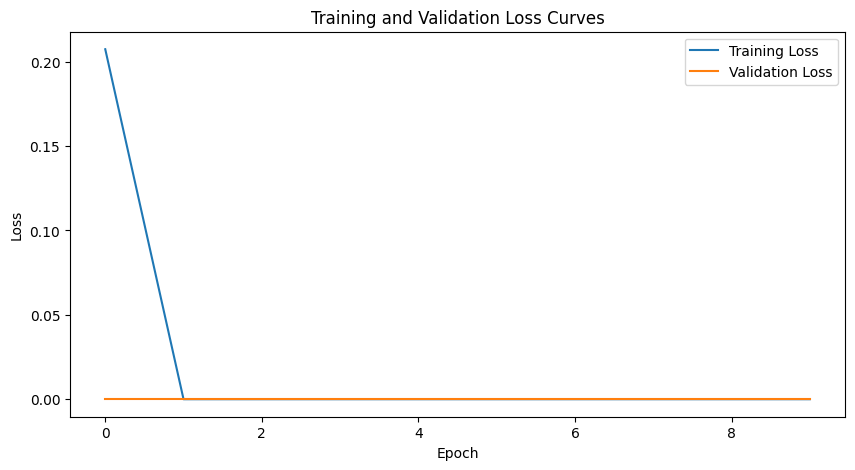

Test Accuracy: 1.0000


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Configuration
class Config:
    sr = 16000  # Sample rate
    duration = 3  # Duration in seconds
    n_fft = 512
    hop_length = 256
    n_mels = 64
    batch_size = 32
    epochs = 10
    lr = 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load protocol and get file paths and labels
def load_protocol(protocol_path, audio_dir):
    file_paths, labels = [], []
    with open(protocol_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # Example: assume second column is the file ID and last column is the label ("bonafide" or "spoof")
            file_id = parts[1]
            label = 0 if parts[-1] == 'bonafide' else 1
            # Construct the full path; adjust extension if needed (.flac)
            file_path = os.path.join(audio_dir, file_id + ".flac")
            if os.path.exists(file_path):
                file_paths.append(file_path)
                labels.append(label)
    return file_paths, labels

# Dataset preparation using soundfile for FLAC files
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, config):
        self.file_paths = file_paths
        self.labels = labels
        self.config = config

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load FLAC audio using soundfile
        audio, sr = sf.read(file_path)
        # Resample if needed
        if sr != self.config.sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=self.config.sr)

        # Pad or trim audio
        if len(audio) > self.config.sr * self.config.duration:
            audio = audio[:self.config.sr * self.config.duration]
        else:
            padding = self.config.sr * self.config.duration - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # Extract mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.config.sr,
            n_fft=self.config.n_fft,
            hop_length=self.config.hop_length,
            n_mels=self.config.n_mels
        )
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)

        return torch.FloatTensor(mel_spec).unsqueeze(0), torch.FloatTensor([label])

# LCNN Model definition
class LCNN(nn.Module):
    def __init__(self):
        super(LCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the correct input size for the first fully connected layer
        # Create a dummy input tensor with the correct shape (batch_size=1 is enough)
        dummy_input = torch.randn(1, 1, config.n_mels, config.sr * config.duration // config.hop_length + 1)
        # Pass the dummy input through the convolutional layers
        dummy_output = self.conv_layers(dummy_input)
        # Get the flattened output size
        fc_input_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(fc_input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Training function remains the same
def train_model(model, train_loader, val_loader, config):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            inputs, labels = inputs.to(config.device), labels.to(config.device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(config.device), labels.to(config.device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc = correct / total

        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses

# Main execution in Colab
if __name__ == '__main__':
    config = Config()

    # Update the following paths based on where you extracted the data in Colab:
    # For example, assume protocol file is in ./ASVspoof5_protocols/ and audio files are in ./flac_D_aa/
    protocol_path = "./ASVspoof5.train.tsv"
    audio_dir = "./flac_T"

    # Load file paths and labels from protocol file
    file_paths, labels = load_protocol(protocol_path, audio_dir)

    # For demonstration, you might choose a subset (e.g., 100 samples) to speed up training
    file_paths = file_paths[:100]
    labels = labels[:100]

    # Split dataset
    train_files, test_files, train_labels, test_labels = train_test_split(
        file_paths, labels, test_size=0.2, random_state=42
    )
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.25, random_state=42
    )

    # Create datasets and dataloaders
    train_dataset = AudioDataset(train_files, train_labels, config)
    val_dataset = AudioDataset(val_files, val_labels, config)
    test_dataset = AudioDataset(test_files, test_labels, config)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    # Initialize model
    model = LCNN().to(config.device)

    # Train model
    train_losses, val_losses = train_model(model, train_loader, val_loader, config)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.savefig('training_curves.png')
    plt.show()

    # Evaluate on test set
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(config.device), labels.to(config.device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    print(f'Test Accuracy: {test_acc:.4f}')
